# C3 metacalibration on a grid


In this notebook we process the rendered galaxy catalogs using the sextractor software, and transport them into a multi-epoch data system, which will later be used to interface with metacalibration


## Objectives

    1 run a minimal version of metacalibration
    
    2 recover constant shear from a grid of postage stamps
 

**TODO** Check the weight map, with someone expert


## Setup

This notebook relies on the:

    * synthetic package & dependencies
    
    * prepared & curated DC2 cutout data file


## Output

    * Recovered constant shear :)
    
The output files are placed in the `./data/` folder


## Contact

In case of questions, contact me at t.varga@physik.lmu.de

In [11]:
import fitsio as fio
import numpy as np
import pandas as pd
import pickle as pickle
import copy
import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import galsim
import astropy.cosmology as cosmology

import images # package from erin sheldon

import synthetic.tools as tools
import synthetic.render.frame as frame
import synthetic.render.render as render
import synthetic.mcal as mcal


import meds
import psfex # The python wrapper

# pixel_scale = 0.2
pixel_scale = 0.264

*** Important *** set the `nprocess` value to the amount of CPU cores you are willing or allowed to use for this notebook

please consider your local server, e.g. don't run heavy calculations on public login nodes

***Note, this notebook can be modestly computationally heavey to execute, consider restricitng the number of galaxies you want to metacalibrate to reduce runtime when testing***

In [12]:
# nprocess = 4
nprocess = 100

In [13]:
# output path for mock image, be sure to place it into a folder where you can write a few GBs of files 
out_path = "./data/"

# Create a rendered image we are going to work on

and run source extractor

This part reproduces where largely identical to the B2 left off

Now we make a grid of roughly similar galaxies. They are defined in a similar parameter space as teh mock catalogs in the B1, B2 notebooks

We will add a constant amount of e1, e2 shear into this image to each galaxy, and then aim to recover it with the metacalibration method

In [14]:
shear1 = 0.02
shear2 = -0.01

shape_std=0.2  # shape noise of the mock galaxy catalog

ra_cen = 50.64516228577292 # RA center of mock pointing [deg]
dec_cen = -40.228830895890404 # DEC center of mock pointing [deg]


In [217]:
np.random.seed(23000)


nobjects = 10000
canvas_size = 10000
padding = 100
mock_catalog = pd.DataFrame()


x = np.linspace(padding, canvas_size - padding, 100)
y = np.linspace(padding, canvas_size - padding, 100)
xx, yy = np.meshgrid(x, y)
xx = xx.flatten()
yy = yy.flatten()


# this is something of an artifact, the X, Y is starting at 0, not at the image center... might need to be fixed
mock_catalog["X"] = xx
mock_catalog["Y"] = yy
# lsizes = np.random.normal(loc=0.4, scale=0.1, size=nobjects)
mock_catalog["TSIZE"] = 2
mock_catalog["FRACDEV"] = 1 #np.random.uniform(0, 1, size=nobjects)
mock_catalog["MAG_I"] = 21 #np.random.normal(loc=22, scale=0.5, size=nobjects)
mock_catalog["FLUX_I"] = tools.toflux(mock_catalog["MAG_I"])


In [190]:
mock_catalog["G1"] = np.random.normal(loc=0, scale=shape_std, size=nobjects) + shear1
mock_catalog["G2"] = np.random.normal(loc=0, scale=shape_std, size=nobjects) + shear2


# The below part is only relevant if we allow shape noise, very large shear values e ~ 1 
# are rendered really poorly by galsim
# 
g1 = mock_catalog["G1"]
g2 = mock_catalog["G2"]
amp = np.sqrt(g1**2 + g2**2) 
# 
ii = amp > 0.8
mock_catalog.loc[ii, 'G1'] *= 0.8 / amp[ii]
mock_catalog.loc[ii, 'G2'] *= 0.8 / amp[ii]

In [ ]:
# For a minimal example we are going to turn off shape noise, and only allow a constant shear for g1 and g2

# mock_catalog["G1"] = shear1
# mock_catalog["G2"] = shear2

# Preparing the grid of postage stamps

## Creating a deeper, detection image and weight map

source detection is traditionally done on coadded images, even when shear estimation is performed per-frame for greater performance.

For this reason, unlike in B1, B2, B3, we are going to create a single, deeper, detection frame

In [191]:
band = 'i'
name = out_path + 'test_canvas_' + band
print(name)
fr = frame.Frame(mock_catalog.to_records(), band=band, name=name,
                     center=(ra_cen, dec_cen), noise_std=1., canvas_size=canvas_size, config_se='data/configs/config.sex')
fr.render(nprocess=nprocess) 

./data/test_canvas_i
starting postage stamp calculations in 100 processes


we also have to create a weight map

**TODO** check the actual values for this!!!

In [192]:
noise = np.ones(shape=(fr.canvas_size, fr.canvas_size)) # this is set as 1, as in this example that's the noise std
wcanvas = galsim.ImageF(noise, wcs=fr.canvas.wcs)
wcanvas.write(name + '_weight.fits', clobber=True)

after rendering, we can run sextractor, and load the results as

In [193]:
fr.extract()

sex ./data/test_canvas_i.fits -c data/configs/config.sex -CATALOG_NAME ./data/test_canvas_i_cat.fits -CHECKIMAGE_NAME ./data/test_canvas_i_seg.fits


here we have access to the sextractor catalog, and the segmentation map

In [194]:
scat = fr.scat.copy()
seg = fio.read("./data/test_canvas_i_seg.fits")

before we go further, let's see the grid of galaxy postage stamps

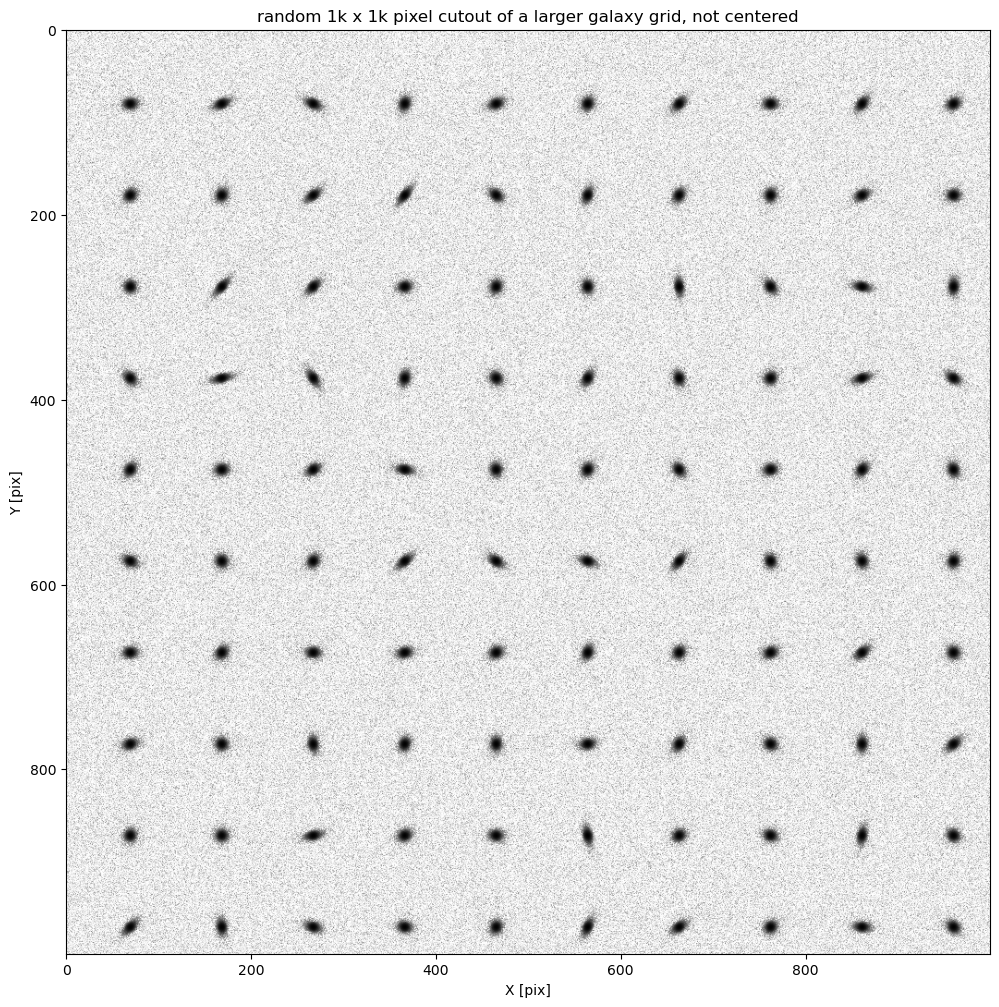

In [195]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

arr = fr.canvas.array[2000:3000, 3000:4000]
ax.imshow(np.arcsinh(arr) / arr, cmap=plt.cm.gray)
ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")
ax.set_title('random 1k x 1k pixel cutout of a larger galaxy grid, not centered')
fig.savefig("./data/grid_illustration.png", bbox_inches="tight")

## Creating a multi epoch data system file (MEDS)

See the C2 notebook

Now we are going to transform the synthetic image, into the multi epoch data system format, which is the last step before we can run metacalibration


In [196]:
objects = fr.scat.copy()

In [197]:
nimage = 1 # one exposure per object, we are simulating coadds with identical observational conditions
nobj = len(objects)
obj_data = meds.util.get_meds_input_struct(nobj, extra_fields=[("X_IMAGE", "f8"), ("Y_IMAGE", "f8")])
obj_data['id'] = objects['NUMBER'] # the source extractor ID, starts with 1, not 0...

# This the size of the bounding box for the object, should be adaptive based on the size of the source
box_sizes = np.round(objects["A_IMAGE"] * objects["B_IMAGE"] * 2 ) *2
box_sizes[box_sizes < 16] = 16 
obj_data['box_size'] = box_sizes

# The below are the positions of the source on the sky and in the image-
# The actual MEDS script uses the sky position based on the image WCS, but this is done completely under the hood
obj_data['ra'] = objects['ALPHAWIN_J2000'] + pixel_scale / 3600 # this is a hack for fortran vs python ordered arrays
obj_data['dec'] = objects['DELTAWIN_J2000'] - pixel_scale / 3600 # this is a hack for fortran vs python ordered arrays
obj_data['X_IMAGE'] = objects['X_IMAGE']
obj_data['Y_IMAGE'] = objects['Y_IMAGE']

In [198]:
path_image = fr.name + ".fits"
path_weight = fr.name + "_weight.fits"
path_seg = fr.name + "_seg.fits"

# Due to some memory reservation issues, we have to tell expicitely how long the longest filename will be.
path_length= np.max((len(path_image), len(path_seg), len(path_weight)))

image_info= meds.util.get_image_info_struct(nimage, path_length)

image_info['image_path'][0] = path_image
image_info['weight_path'][0] = path_weight
image_info['seg_path'][0] = path_seg
image_info['magzp'] = 30.

config = {'first_image_is_coadd': False,'cutout_types':['weight', 'seg'],'psf_type':'psfex'}

Since this is a synthetic image, we know the exact PSF. We take this from the galsim PSF model used in rendering the images

In [199]:
pex = frame.MockPSF(fr.df.image_epsf)
psf_data = [pex,]

now all is set for running the MEDSMaker

In [200]:
mm = meds.MEDSMaker(obj_data=obj_data, image_info=image_info, config=config, psf_data=psf_data)
mm.write(out_path + "grid.meds")

writing cutouts for: ['image', 'weight', 'seg']
file    1 of    1: 'b'./data/test_canvas_i.fits''
    first cut:   10001 of  10001 objects
    second cut:  10001 of  10001 objects
10001/10001 had ncut > 0
setting start rows and pixel count
total pixels: 24242476
setting psf layout for PSFEx


/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/meds/util.py:380: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  phat = numpy.array([-1.0*sinp,cosp,0.0]).T


meds layout build time: 0.237541 seconds
opening output MEDS file: './data/grid.meds'
writing object_data
writing image_info
writing metadata
    reserving image mosaic
    reserving weight mosaic
    reserving seg mosaic
    reserving psf mosaic
writing image cutouts
    1/1 image b'./data/test_canvas_i.fits'
    no background for image
writing weight cutouts
    1/1 weight b'./data/test_canvas_i_weight.fits'
writing seg cutouts
    1/1 seg b'./data/test_canvas_i_seg.fits'
writing psf cutouts
output is in: ./data/grid.meds


now let's inspect the meds files, if all goes well, there should be a galaxy in each postage stamp cutout

In [201]:
m = meds.MEDS(out_path + "grid.meds")

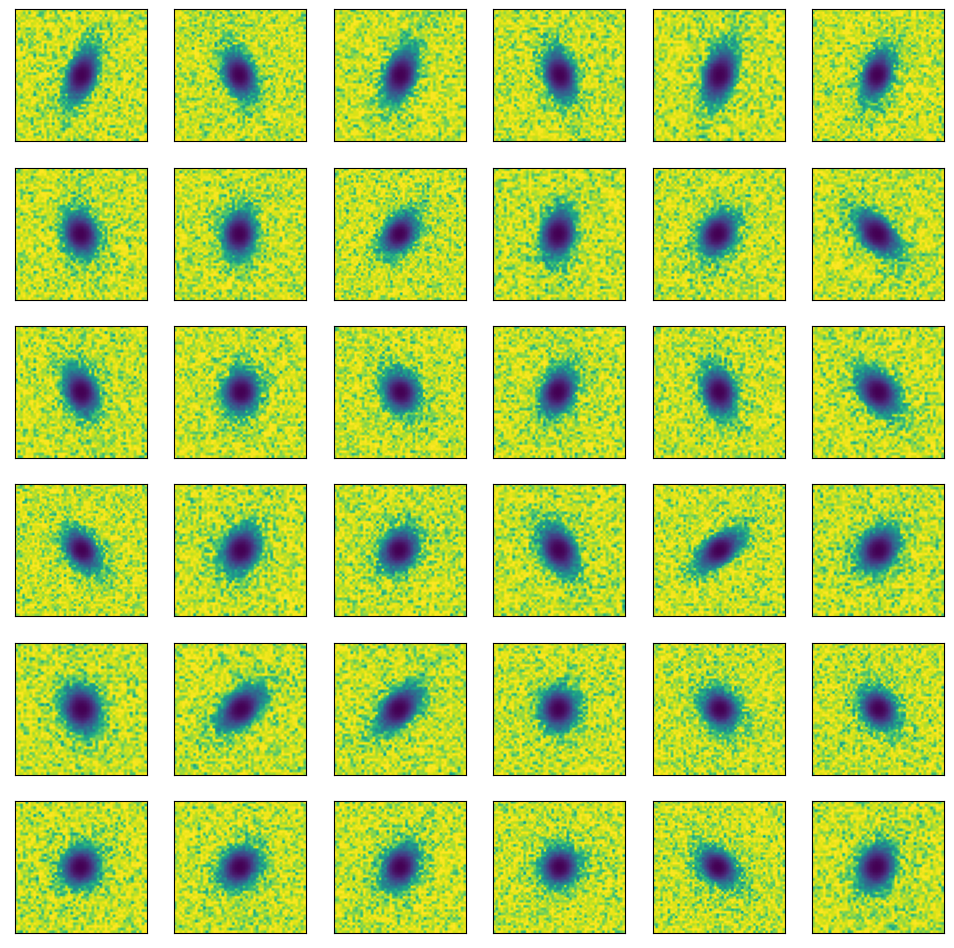

In [202]:
fig, axarr = plt.subplots(ncols=6, nrows=6, figsize=(12,12))
# fig.subplots_adjust(wspace=0.01)
for i, ax in enumerate(axarr.flatten()):
    im = m.get_cutout(i, 0, 'image')
    ax.imshow(np.arcsinh(im) / im)
    ax.set_xticks([])
    ax.set_yticks([])    
fig.savefig("./data/grid_illustration_meds.png", bbox_inches="tight")

/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


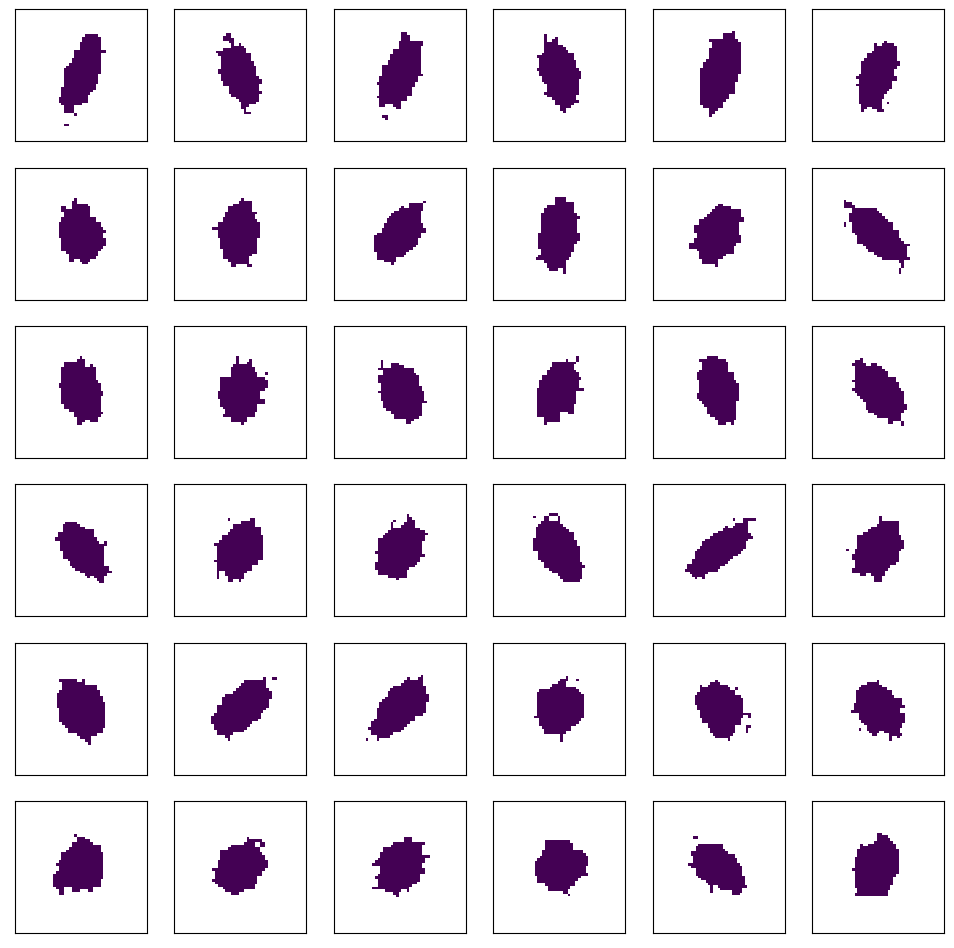

In [203]:
fig, axarr = plt.subplots(ncols=6, nrows=6, figsize=(12,12))
# fig.subplots_adjust(wspace=0.01)
for i, ax in enumerate(axarr.flatten()):
    im = m.get_cutout(i, 0, 'seg')
    ax.imshow(np.arcsinh(im) / im)
    ax.set_xticks([])
    ax.set_yticks([])    

# Running metacalibration

In [204]:
input_name = out_path + "grid.meds"

we have to prepare a set of instructions for the metacal runner

The actual calculation is split up to jobs, each processing a set of independent postage stamps, and the results are written to file

In [211]:
# The highest number of  objects to include from the sextractor detection catalog. 
# maxnum = 10000
maxnum = 1000 # for the example, you might be better off reducing the number from 40k down to fewer galaxies.

In [212]:
outfile_names = out_path + "grid_mcal" # file name root of output (will have additional _01 _02 etc appended to it)

infodicts = mcal.infomaker(maxnum, input_name, outfile_names, nchunk=nprocess)

In [213]:
mcal.multi_mcal(infodicts, nprocess=nprocess)

starting metacal calculations in 100 processes
     singular covariance
    pars at singular:     -0.3      -0.3  -3.11e-10  -0.00978     0.311      0.04 
     singular covariance
    pars at singular:     -0.3      -0.3  -1.7e-10  4.56e-09     0.304      0.04 
     singular covariance
    pars at singular:     -0.3      -0.3  2.49e-10  -0.00978     0.311      0.04 
     singular covariance
    pars at singular:     -0.3      -0.3  -2.37e-09  1.48e-07     0.311      0.04 
     singular covariance
    pars at singular:     -0.3      -0.3  2.58e-09  -2.77e-07     0.311      0.04 
     singular covariance
    pars at singular:     -0.3      -0.3  3.15e-09  -4.23e-07     0.311      0.04 
     singular covariance
    pars at singular:   -0.301    -0.299  2.76e-09     3e-06     0.311      0.04 
     singular covariance
    pars at singular:     -0.3      -0.3  2.29e-09   0.00978     0.311      0.04 
     singular covariance
    pars at singular:     -0.3      -0.3  -1.43e-09  -0.00978     0.

now we need to read in the results from file

In [214]:
tab = mcal.collater(infodicts)

In [215]:
gest1_raw =tab["g_noshear"][:, 0].mean()
gest2_raw =tab["g_noshear"][:, 1].mean()

gest1 =tab["g_noshear"][:, 0].mean() / tab['r11'].mean()
gest2 =tab["g_noshear"][:, 1].mean() / tab['r22'].mean()



In [216]:
print("the measured shape  <e> with",maxnum ,"galaxies")
print("g1 = {:.4f}".format(gest1_raw), "the input shape is", shear1)
print("g2 = {:.4f}".format(gest2_raw), "the input shape is", shear2)
print('')
print('METACALIBRATION:')
print("the measured shape  <e> / <R> with",maxnum ,"galaxies")
print("g1 = {:.4f}".format(gest1), "the input shape is", shear1)
print("g2 = {:.4f}".format(gest2), "the input shape is", shear2)

the measured shape  <e> with 10000 galaxies
g1 = 0.0151 the input shape is 0.02
g2 = -0.0098 the input shape is -0.01

METACALIBRATION:
the measured shape  <e> / <R> with 10000 galaxies
g1 = 0.0198 the input shape is 0.02
g2 = -0.0129 the input shape is -0.01
